Parameters:
total num steps: 100000
delta alpha option: dynamic
delta alpha start: 0.95
delta alpha end: 0.9

current epsilon: 0.01
['012', '013', '014', '023', '024', '034', '123', '124', '134', '234']
initial position estimate: [10.2 36.   6. ]
target position: [10.  35.   0.1]
normalize direction: [-0.033403   -0.16701498 -0.98538837]
previous position estimate: [10.2000334  36.00016701  6.00098539]
current epsilon: 0.3
['012', '013', '014', '023', '024', '034', '123', '124', '134', '234']
initial position estimate: [10.2 36.   6. ]
target position: [10.  35.   0.1]
normalize direction: [-0.033403   -0.16701498 -0.98538837]
previous position estimate: [10.2000334  36.00016701  6.00098539]
epsilon: 0.01
action counts: {'012': 98, '013': 113, '014': 114, '023': 99093, '024': 96, '034': 96, '123': 108, '124': 106, '134': 84, '234': 92}
Q values: {'012': 0.07676583250380907, '013': 0.5992802353280924, '014': 0.5133058690205733, '023': 0.6274489599224748, '024': 0.5290677226349002, '034'

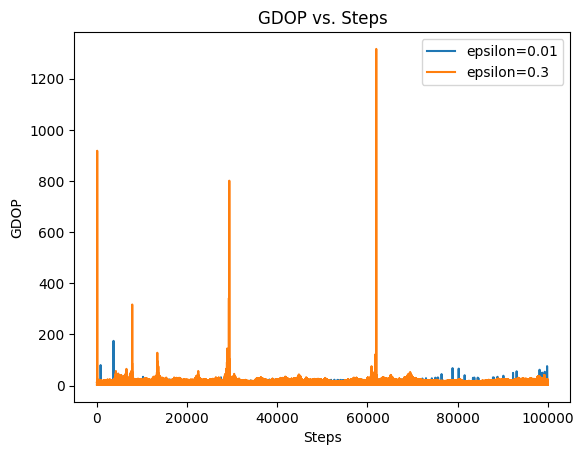

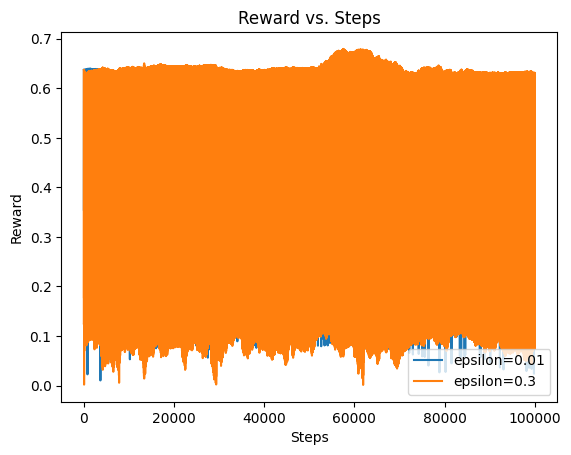

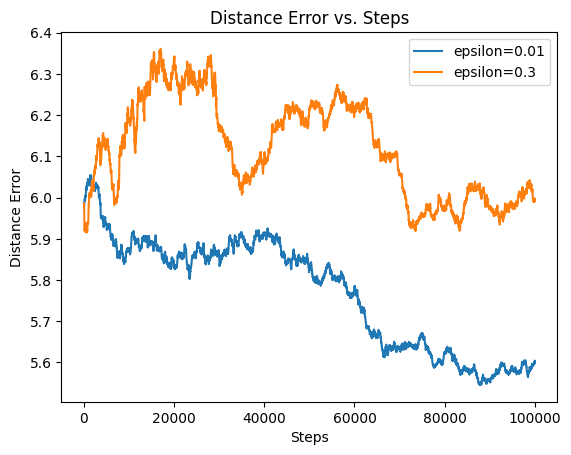

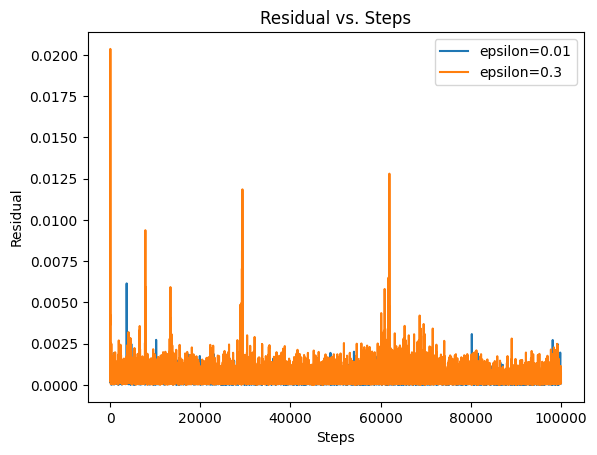

In [ ]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

### Step 1: Initialize the problem parameters.

num_anchor_nodes = 5

total_steps = 100000
# total_steps = 10000

# Number of anchor nodes chosen at each time step (action A)
action_num_chosen_anchor_nodes = 3

# Initialize anchor node positions and target position
anchor_positions = np.array([[11, 30, 10], [5, 40, -20], [15, 40, 30], [5, 35, 20], [15, 35, -10]], dtype=float)
target_position = [10, 35, 0.1]

# Define two epsilon values
epsilons = [0.01, 0.3]

# Calculate the centroid of anchor node positions
centroid = np.mean(anchor_positions, axis=0)

# Set the initial position estimate as the centroid
position_initial_estimate = centroid

########################################################

# Strength of initial guess
strength_initial_guess = 0.001

# Bound from target (distance) to restrict further movement
bound_limit = 10

########################################################
# Alpha value for updating the position estimate (on the Delta vector)
# scales how "fast" the position estimate changes (too fast originally)
delta_alpha = 0.95

delta_alpha_start = 0.95
delta_alpha_end = 0.9
delta_alpha_diff = delta_alpha_start - delta_alpha_end
########################################################

# Scales the scaling (alpha) on the delta used to update the new position
# estimate based on the three delta alpha values above and the current step
# (i.e., scales alpha down starting at delta_alpha_start down till
# delta_alpha_end -- assuming delta_alpha_start >= delta_alpha_end
# -- with a uniform decrease with step number)
def dynamic_delta_alpha(current_step):
    return delta_alpha_start - (current_step / total_steps) * delta_alpha_diff


# Function to calculate Euclidean distance
def euclidean_distance(a, b):
    return np.linalg.norm(a - b)


# Function to calculate GDOP (Geometric Dilution of Precision)
def calculate_gdop(jacobian):
    G = np.linalg.inv(np.dot(jacobian.T, jacobian))
    gdop = np.sqrt(np.trace(G))
    return gdop


# Function to calculate reward based on GDOP
def calculate_reward(gdop):
    return np.sqrt(10 / 3) / gdop if gdop > 0 else 0


# Find Jacobian (assume d is a constant when calculating partial derivatives)
def calculate_jacobian(selected_positions_array, position_estimate, pseudorange_array):
    DEBUG = False

    num_functions = selected_positions_array.shape[0]

    # three nodes chosen (arbitrary number of functions, but should be 3 in this case)
    assert num_functions == 3

    jacobian = np.zeros((num_functions, 3))

    for i in range(num_functions):
        current_node_position = selected_positions_array[i]

        # coordinate format (x, y, z)
        delta_x = current_node_position[0] - position_estimate[0]
        delta_y = current_node_position[1] - position_estimate[1]
        delta_z = current_node_position[2] - position_estimate[2]

        jacobian[i] = -np.array([delta_x, delta_y, delta_z]) / pseudorange_array[i]

    if DEBUG:
        print(f"node positions: {selected_positions_array}")
        print(f"position estimate: {position_estimate}")
        print(f"jacobian: {jacobian}")

    return jacobian


def get_residual_vector(selected_positions_array, position_estimate, pseudorange_array, added_noise=False):
    num_functions = selected_positions_array.shape[0]

    # three nodes chosen (arbitrary number of functions, but should be 3 in this case)
    assert num_functions == 3

    residual = np.zeros((num_functions, ))

    for i in range(num_functions):
        current_position = selected_positions_array[i]

        # added_noise -- adds some noise to the first term on the right of f,g,h (testing purposes)
        if added_noise:
            residual[i] = (euclidean_distance(current_position, position_estimate)
                           + np.random.uniform(-0.0001, 0.0001, 1)[0]) \
                          - pseudorange_array[i]
        else:
            residual[i] = euclidean_distance(current_position, position_estimate) - pseudorange_array[i]

    return residual


def get_new_residual_vector(selected_positions_array, previous_position_estimate, target_position, pseudorange_array,
                            added_noise=False):
    DEBUG = False

    num_functions = selected_positions_array.shape[0]

    # three nodes chosen (arbitrary number of functions, but should be 3 in this case)
    assert num_functions == 3

    residual = np.zeros((num_functions,))

    for i in range(num_functions):
        current_position = selected_positions_array[i]

        if added_noise:
            residual[i] = pseudorange_array[i] - (euclidean_distance(current_position, previous_position_estimate) +
                                              np.random.uniform(-0.0001, 0.0001, 1)[0])
        else:
            residual[i] = pseudorange_array[i] - euclidean_distance(current_position, previous_position_estimate)

    if DEBUG:
        print(f"residual: {residual}")

    return residual


# Constants for delta_alpha_option
#    None
#    "static"
#    "dynamic"
def get_new_position_estimate(old_position_estimate, jacobian, residual, current_step,
                              delta_alpha_option=None):
    DEBUG = False

    delta_vector = np.linalg.inv(np.dot(jacobian.T, jacobian)) @ jacobian.T @ residual

    if DEBUG:
        print(f"delta vector: {delta_vector}")

    if delta_alpha_option is None:
        return old_position_estimate + delta_vector
    elif delta_alpha_option == "static":
        return old_position_estimate + delta_alpha * delta_vector
    elif delta_alpha_option == "dynamic":
        return old_position_estimate + dynamic_delta_alpha(current_step) * delta_vector


# Function to create custom hashing string based on indices of anchor nodes chosen
def get_custom_hashing_string(anchor_nodes_index_list):
    return np.sort(anchor_nodes_index_list)


# Function to initialize the action counts to all 0 (each action)
def initialize_action_counts(custom_hash_strings_list):
    action_values_dict = {}

    for custom_hash_string in custom_hash_strings_list:
        action_values_dict[custom_hash_string] = 0

    return action_values_dict


# Function to initialize Q values (as dict with hashing strings as keys)
# initial values of 0 when starting out (seems like choice of initial Q values does not matter once every action has
# been chosen at least once)
# it can be shown that the assignment of the anchor nodes to functions f, g, h does not matter when evaluating G
# (permutation of the rows on J can be written as P*J and finding J^T J will reduce P^T P to the identity matrix)
def initialize_Q_values(custom_hash_strings_list):
    print(custom_hash_strings_list)

    q_values_dict = {}

    for custom_hash_string in custom_hash_strings_list:
        q_values_dict[custom_hash_string] = 0

    return q_values_dict


# Function to get the list of custom hash strings using anchor position indices as part of the string (uses helper
# function)
def get_custom_hash_strings_list():
    num_loops = action_num_chosen_anchor_nodes
    max_num = num_anchor_nodes

    return get_custom_hash_strings_list_helper(num_loops, max_num, 0, max_num - num_loops + 1, "", [])


# Function to recursively create a nested loop to create the hash strings (arbitrary number of nested loops)
def get_custom_hash_strings_list_helper(num_loops, max_num, low_bound, up_bound, current_element, accumulator):
    DEBUG = False

    # when the num of loops has been reached
    if up_bound > max_num:
        return [current_element]
    else:
        if DEBUG:
            print(f"level: {low_bound}")
            print(f"up bound: {up_bound}")

        for i in range(low_bound, up_bound):
            if DEBUG:
                print(f"i: {i}")

            new_current_element = current_element + f"{i}"

            # the low bound is the current i + 1 (so subsequent values are larger than it)
            intermediate_list = get_custom_hash_strings_list_helper(num_loops,
                                                                    max_num,
                                                                    i + 1,
                                                                    up_bound + 1,
                                                                    new_current_element,
                                                                    accumulator)

            if DEBUG:
                print(f"current: {current_element}")
                print(f"intermediate: {intermediate_list}")

            accumulator.extend(intermediate_list)

        if DEBUG:
            print(f"accumulator: {accumulator}")
            print(f"going up...")

    # don't want to add duplicate copies of accumulator when returning up the recursive stack
    # reference to the accumulator is passed so only need to return it at the end
    # accumulator already updated when reaching the end of the current loop
    if low_bound == 0:
        return accumulator
    else:
        return []


# Function to get the custom hash string with the highest Q value (handles ties too)
def get_custom_hash_string_max_Q_value(q_values_dict):
    DEBUG = False

    max_Q_value = max(q_values_dict.values())

    max_Q_value_items_dict = dict(filter(lambda item: item[1] == max_Q_value,
                                         q_values_dict.items()))

    max_Q_value_custom_hash_strings_list = list(map(lambda item: item[0], max_Q_value_items_dict.items()))

    num_actions_max_Q_value = len(max_Q_value_custom_hash_strings_list)

    if DEBUG:
        print(f"max_Q_value_items_dict: {max_Q_value_items_dict}")
        print(f"max_Q_value_custom_hash_strings_list: {max_Q_value_custom_hash_strings_list}")

    # choose a random action if there are ties (multiple actions)
    if num_actions_max_Q_value > 1:
        max_Q_value_action_index = np.random.choice(num_actions_max_Q_value,
                                                    1,
                                                    replace=False)[0]

        return max_Q_value_custom_hash_strings_list[max_Q_value_action_index]

    # if there's only one action with the max value, then just return it
    else:
        return max_Q_value_custom_hash_strings_list[0]


# Function to parse the string to recover the indices stored in the custom hash string
# Only handles single digits to parse
def get_anchor_indices_list_from_custom_hash_string(custom_hash_string):
    DEBUG = False

    if DEBUG:
        print(f"random hash string: {custom_hash_string}")

    num_indices = len(custom_hash_string)

    anchor_indices_list = []

    for i in range(num_indices):
        anchor_indices_list.append(int(custom_hash_string[i]))

    return anchor_indices_list


# Function to parse the string to recover the indices stored in the custom hash string
def get_custom_hash_string_from_anchor_indices(anchor_indices):
    custom_hash_string = ""

    for anchor_index in anchor_indices:
        custom_hash_string += f"{anchor_index}"

    return custom_hash_string


# Function to provide the previous position estimate (for residual) in direction of target position
def initialize_previous_position_estimate(strength_initial_guess, initial_position_estimate, target_position):
    DEBUG = True

    direction_to_target_from_estimate = target_position - initial_position_estimate
    normalize_direction = direction_to_target_from_estimate / np.linalg.norm(direction_to_target_from_estimate)

    previous_position_estimate = initial_position_estimate - strength_initial_guess * normalize_direction

    # add noise just like pseudorange
    previous_position_estimate_noisy = [previous_position_estimate[i]
                                        + np.random.uniform(-0.0001, 0.0001, 1)[0] for i in range(3)]

    if DEBUG:
        print(f"initial position estimate: {initial_position_estimate}")
        print(f"target position: {target_position}")
        print(f"normalize direction: {normalize_direction}")
        print(f"previous position estimate: {previous_position_estimate}")

    return previous_position_estimate


### Step 2: Implement the Bandit Algorithm.

if __name__ == "__main__":
    # Some constants
    DEBUG = False
    NEW_RESIDUAL = True
    ADDED_NOISE = False
    DELTA_ALPHA_OPTION = "dynamic"

    # Print out parameters
    print(f"Parameters:")
    print(f"total num steps: {total_steps}")
    print(f"delta alpha option: {DELTA_ALPHA_OPTION}")

    if DELTA_ALPHA_OPTION == "static":
        print(f"delta alpha: {delta_alpha}")
    elif DELTA_ALPHA_OPTION == "dynamic":
        print(f"delta alpha start: {delta_alpha_start}")
        print(f"delta alpha end: {delta_alpha_end}")

    print()

    # Initialize gdop vector, rewards vector, euclidean distance error vector for each epsilon
    gdop_dict = {}
    rewards_dict = {}
    euclidean_distance_error_dict = {}

    # Get list of custom hash strings for the various possible actions
    # focus on combinations of actions (order within chosen group of anchor nodes does not matter)
    custom_hash_strings_list = get_custom_hash_strings_list()

    # Initialize action counts
    action_counts_dict = {}

    # Initialize Q-values
    q_values_dict = {}

    # Initialize residuals
    residuals_dict = {}

    # Loop through the epsilon values
    for epsilon in epsilons:
        print(f"current epsilon: {epsilon}")

        # Initialize gdop vector
        gdop_vec = np.zeros((total_steps, ))

        # Initialize rewards vector
        rewards_vec = np.zeros((total_steps, ))

        # Initialize euclidean distance error vector
        euclidean_distance_error_vec = np.zeros((total_steps, ))

        # Initializing the 'position_estimate' to 'position_initial_estimate'
        position_estimate = position_initial_estimate.copy()

        # Initialize action counts for each epsilon
        action_counts_dict[epsilon] = initialize_action_counts(custom_hash_strings_list)

        # Initialize Q-values for each epsilon
        q_values_dict[epsilon] = initialize_Q_values(custom_hash_strings_list)

        # Initialize residuals for each epsilon
        residuals_2norm_vec = np.zeros((total_steps, ))

        # Initialize previous time step position estimate
        previous_position_estimate = initialize_previous_position_estimate(strength_initial_guess,
                                                                           position_estimate,
                                                                           np.array(target_position))

        # Main loop for the epsilon-greedy bandit algorithm
        for step_i in range(total_steps):
            if DEBUG:
                print(f"step: {step_i}")

            # Select three anchor nodes (action A)
            # Get random number from uniform dist on [0, 1)
            if np.random.rand(1) < epsilon:
                # Exploration: Choose random actions
                if DEBUG:
                    print(f"Exploration")

                # choose three random nodes from the given anchor positions (without replacement, uniform probability)
                # get indices for the custom hash string to update the action counts and Q-values
                # then get elements from indices above (anchor_positions)
                action_chosen_anchor_indices = np.random.choice(num_anchor_nodes,
                                                                action_num_chosen_anchor_nodes,
                                                                replace=False)

                # important: need to sort first for the hash value to work
                action_chosen_anchor_indices = np.sort(action_chosen_anchor_indices)

                anchor_indices_custom_hash_string = \
                    get_custom_hash_string_from_anchor_indices(action_chosen_anchor_indices)

                if DEBUG:
                    print(f"anchor indices: {action_chosen_anchor_indices}")

                action_chosen_anchor_nodes = anchor_positions[action_chosen_anchor_indices]
                selected_positions = action_chosen_anchor_nodes.copy()
            else:
                # Exploitation: Choose actions with highest Q-values
                if DEBUG:
                    print(f"Exploitation")

                # for ties, randomly choose one of the actions (group of three anchor node positions) with the
                # highest Q-value
                custom_hash_string_max_Q_value = get_custom_hash_string_max_Q_value(q_values_dict[epsilon])
                anchor_indices_custom_hash_string = custom_hash_string_max_Q_value

                # get list of anchor indices
                action_chosen_anchor_indices = get_anchor_indices_list_from_custom_hash_string(custom_hash_string_max_Q_value)

                if DEBUG:
                    print(f"anchor indices: {action_chosen_anchor_indices}")

                action_chosen_anchor_nodes = anchor_positions[action_chosen_anchor_indices]
                selected_positions = action_chosen_anchor_nodes.copy()

            if DEBUG:
                print(f"selected positions: {selected_positions}")

            # Code for determining pseudoranges
            # Modified to be dynamic for number of chosen anchor nodes (instead of hardcoded, changed from 3)
            pseudoranges = [
                euclidean_distance(selected_positions[i], position_estimate) + np.random.uniform(-0.0001, 0.0001, 1)[0]
                for i in range(action_num_chosen_anchor_nodes)]

            # Determine the 'jacobian' matrix based on the selected anchor nodes
            jacobian = calculate_jacobian(selected_positions, position_estimate, pseudoranges)

            if DEBUG:
                print(f"jacobian:")
                print(jacobian)

            # Determine the 'gdop' value GDOP(A) from the calculated 'jacobian'
            gdop = calculate_gdop(jacobian)

            # Determine the 'reward' R(A) using the 'gdop' value
            reward = calculate_reward(gdop)

            # Update action counts N(A)
            action_counts_dict[epsilon][anchor_indices_custom_hash_string] += 1

            # N might not be the current time step (need the previous number of times action was chosen -- previous action count value)
            # Update Q-values Q(A)
            q_values_dict[epsilon][anchor_indices_custom_hash_string] \
                += (1 / action_counts_dict[epsilon][anchor_indices_custom_hash_string]) \
                   * (reward - q_values_dict[epsilon][anchor_indices_custom_hash_string])

            # Update position estimate
            # Edit: use new residual formula (previous and current time steps, d hat uses position estimate from
            #  previous time step)
            # Edit 2: very sensitive...a slight change can produce a large change (produce singular matrix error when
            #  computing inverse)
            if NEW_RESIDUAL:
                residual = get_new_residual_vector(selected_positions, previous_position_estimate, target_position,
                                                   pseudoranges, added_noise=ADDED_NOISE)
            else:
                residual = get_residual_vector(selected_positions, position_estimate, pseudoranges,
                                               added_noise=ADDED_NOISE)

            # Need to bound how much the position can change (for testing with previous time step)
            possible_position_estimate = get_new_position_estimate(position_estimate, jacobian, residual, step_i,
                                                                   delta_alpha_option=DELTA_ALPHA_OPTION)

            # do NOT update (keep the current position estimate) if outside the bounds
            if euclidean_distance(possible_position_estimate, target_position) <= bound_limit:
                previous_position_estimate = position_estimate
                position_estimate = possible_position_estimate

            # Store GDOP(A), R(A), Euclidean distance error for each step of 'total_steps'
            gdop_vec[step_i] = gdop
            rewards_vec[step_i] = reward
            euclidean_distance_error_vec[step_i] = euclidean_distance(position_estimate, target_position)

            # Store residual for each step of 'total_steps'
            # since the residual is a vector, just take the 2-norm for visualization
            residuals_2norm_vec[step_i] = np.linalg.norm(residual)

        # Store GDOP values, rewards, Euclidean distance errors for each epsilon
        gdop_dict[epsilon] = gdop_vec
        rewards_dict[epsilon] = rewards_vec
        euclidean_distance_error_dict[epsilon] = euclidean_distance_error_vec

        # Store residual for each epsilon
        residuals_dict[epsilon] = residuals_2norm_vec

    ### Step 3: Plot and analyze the results.

    for epsilon in epsilons:
        print(f"epsilon: {epsilon}")

        if DEBUG:
            print(f"gdop: {gdop_dict[epsilon]}")
            print(f"rewards: {rewards_dict[epsilon]}")
            print(f"euclidean: {euclidean_distance_error_dict[epsilon]}")

        print(f"action counts: {action_counts_dict[epsilon]}")
        print(f"Q values: {q_values_dict[epsilon]}")

    print(f"final position estimate: {position_estimate}")

    # Plot GDOP vs. Steps for each step and each epsilon
    plt.figure()

    for epsilon in epsilons:
        plt.plot(range(total_steps), gdop_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('GDOP')
    plt.legend()
    plt.title('GDOP vs. Steps')

    # Plot Reward vs. Steps for each step and each epsilon
    plt.figure()

    for epsilon in epsilons:
        plt.plot(range(total_steps), rewards_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.legend()
    plt.title('Reward vs. Steps')

    # Plot Distance Error vs. Steps for each step and each epsilon
    plt.figure()

    for epsilon in epsilons:
        plt.plot(range(total_steps), euclidean_distance_error_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Distance Error')
    plt.legend()
    plt.title('Distance Error vs. Steps')

    # Check convergence and contribution to Delta from the residual component
    # Plot Residual vs. Steps for each step and each epsilon
    plt.figure()

    for epsilon in epsilons:
        plt.plot(range(total_steps), residuals_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Residual')
    plt.legend()
    plt.title('Residual vs. Steps')

    # Show all plots
    plt.show()


epsilon: 0.01
action counts: {'012': 98, '013': 113, '014': 114, '023': 99093, '024': 96, '034': 96, '123': 108, '124': 106, '134': 84, '234': 92}
Q values: {'012': 0.07676583250380907, '013': 0.5992802353280924, '014': 0.5133058690205733, '023': 0.6274489599224748, '024': 0.5290677226349002, '034': 0.16971990153229655, '123': 0.3690898092859961, '124': 0.3457138071240731, '134': 0.17079602942396221, '234': 0.08808509333266067}
epsilon: 0.3
action counts: {'012': 3030, '013': 3039, '014': 3036, '023': 73077, '024': 2942, '034': 3014, '123': 2976, '124': 3043, '134': 2876, '234': 2967}
Q values: {'012': 0.09932698452996197, '013': 0.6120496836792523, '014': 0.5132975162115145, '023': 0.6357002271056602, '024': 0.5225236367378726, '034': 0.19182121952343242, '123': 0.3422104098686778, '124': 0.31865536170903425, '134': 0.2206689832495033, '234': 0.13700992833462688}
final position estimate: [10.66772077 36.50404741  5.86671496]


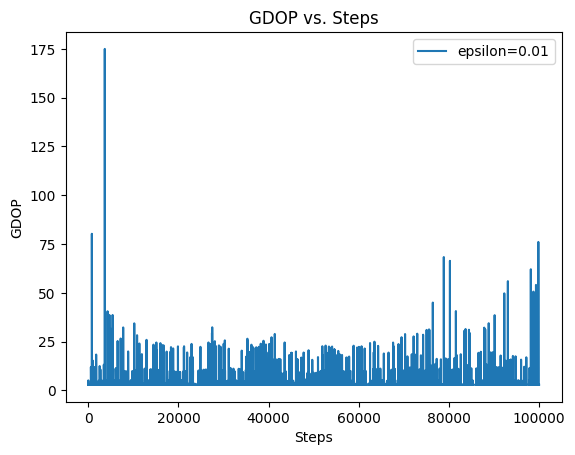

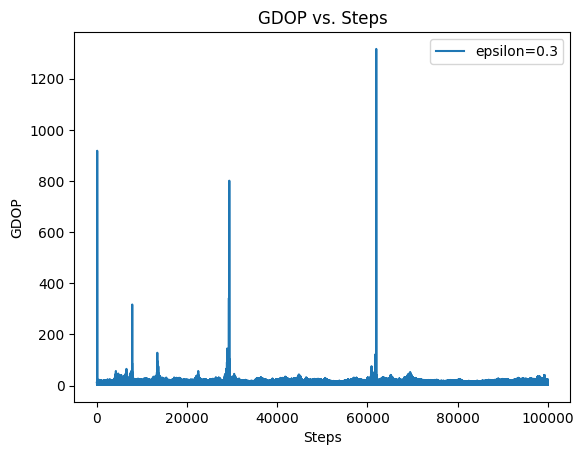

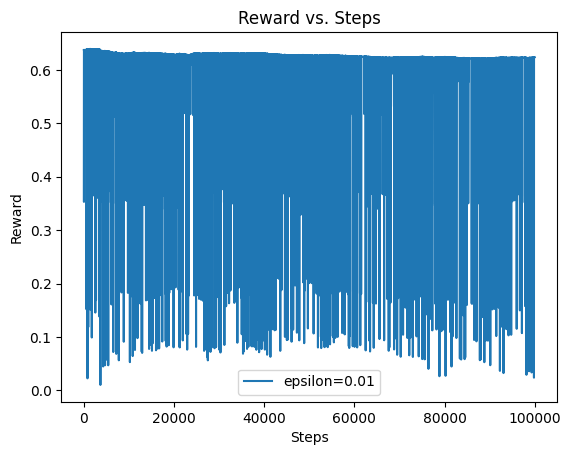

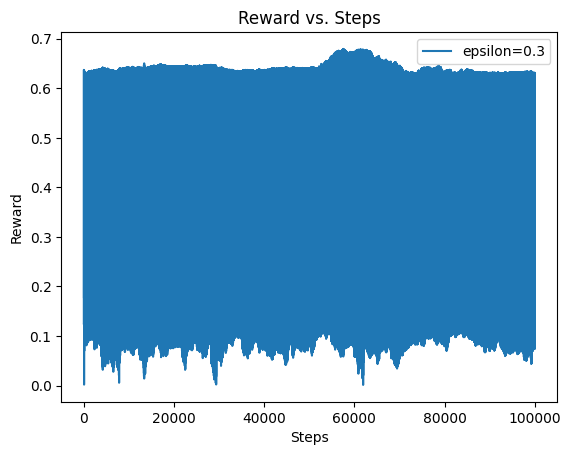

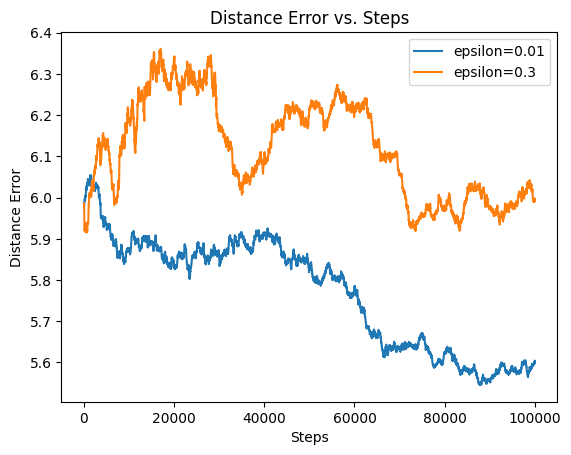

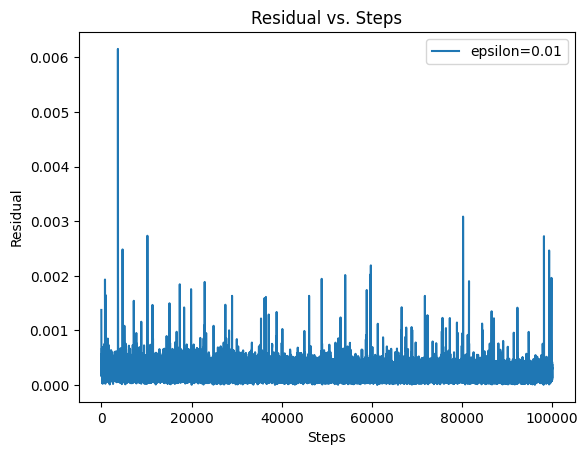

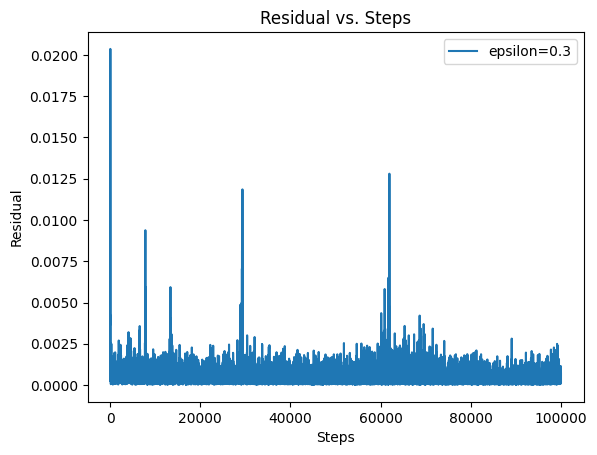

In [ ]:
### Print the plots separately to better see the differences

for epsilon in epsilons:
    print(f"epsilon: {epsilon}")

    if DEBUG:
        print(f"gdop: {gdop_dict[epsilon]}")
        print(f"rewards: {rewards_dict[epsilon]}")
        print(f"euclidean: {euclidean_distance_error_dict[epsilon]}")

    print(f"action counts: {action_counts_dict[epsilon]}")
    print(f"Q values: {q_values_dict[epsilon]}")

print(f"final position estimate: {position_estimate}")

# Plot GDOP vs. Steps for each step and each epsilon
for epsilon in epsilons:
    plt.figure()
    plt.plot(range(total_steps), gdop_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('GDOP')
    plt.legend()
    plt.title('GDOP vs. Steps')

# Plot Reward vs. Steps for each step and each epsilon
for epsilon in epsilons:
    plt.figure()
    plt.plot(range(total_steps), rewards_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Reward')
    plt.legend()
    plt.title('Reward vs. Steps')

# Plot Distance Error vs. Steps for each step and each epsilon
plt.figure()

for epsilon in epsilons:
    plt.plot(range(total_steps), euclidean_distance_error_dict[epsilon], label=f'epsilon={epsilon}')

plt.xlabel('Steps')
plt.ylabel('Distance Error')
plt.legend()
plt.title('Distance Error vs. Steps')

# Check convergence and contribution to Delta from the residual component
# Plot Residual vs. Steps for each step and each epsilon
for epsilon in epsilons:
    plt.figure()
    plt.plot(range(total_steps), residuals_dict[epsilon], label=f'epsilon={epsilon}')

    plt.xlabel('Steps')
    plt.ylabel('Residual')
    plt.legend()
    plt.title('Residual vs. Steps')

# Show all plots
plt.show()